In [4]:
import pandas as pd
import numpy as np
import mlflow

import mlflow.prophet
from mlflow.tracking import MlflowClient
from prophet import Prophet
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error

In [5]:
gasoline = pd.read_csv("../data/fuel_prices.csv", index_col=0)
gasoline = gasoline[["BENZINA"]]
gasoline.reset_index(inplace=True) 
gasoline = gasoline.rename(columns={"DATA_RILEVAZIONE":"ds", "BENZINA":"y"})
gasoline.head()

,ds,y
0,2005-01-03,1115.75
1,2005-01-10,1088.00
2,2005-01-17,1088.14
3,2005-01-24,1090.01
4,2005-01-31,1132.11


In [6]:
train_df = gasoline.head(round(len(gasoline)*0.8))
test_df = gasoline.tail(round(len(gasoline)*0.2))

print(train_df.shape)
print(test_df.shape)

(745, 2)
(186, 2)


In [11]:
train_df.tail()

,ds,y
740,2019-11-18,1573.81
741,2019-11-25,1576.50
742,2019-12-02,1580.78
743,2019-12-09,1580.43
744,2019-12-16,1578.01


In [12]:
test_df.head()

,ds,y
745,2020-01-06,1590.14
746,2020-01-13,1593.76
747,2020-01-20,1587.11
748,2020-01-27,1587.13
749,2020-02-03,1570.49


In [7]:
forecaster = Prophet()
forecaster.fit(train_df)

12:25:53 - cmdstanpy - INFO - Chain [1] start processing
12:25:53 - cmdstanpy - INFO - Chain [1] done processing


In [9]:
future = forecaster.make_future_dataframe(periods=len(test_df), include_history=False)
future

,ds
0,2019-12-17
1,2019-12-18
2,2019-12-19
3,2019-12-20
4,2019-12-21
...,...
181,2020-06-15
182,2020-06-16
183,2020-06-17
184,2020-06-18


In [10]:
forecast = forecaster.predict(future)

forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

,ds,yhat,yhat_lower,yhat_upper
0,2019-12-17,1638.029727,1568.401523,1700.300033
1,2019-12-18,1527.512971,1463.702061,1588.609674
2,2019-12-19,1527.980510,1463.788090,1594.470525
3,2019-12-20,1528.456908,1459.811869,1594.026613
4,2019-12-21,1528.932654,1467.222672,1588.749821
...,...,...,...,...
181,2020-06-15,1672.024641,1604.049245,1738.821596
182,2020-06-16,1724.545120,1661.676496,1793.045458
183,2020-06-17,1613.624532,1542.053861,1678.778821
184,2020-06-18,1613.676429,1545.918101,1674.595366


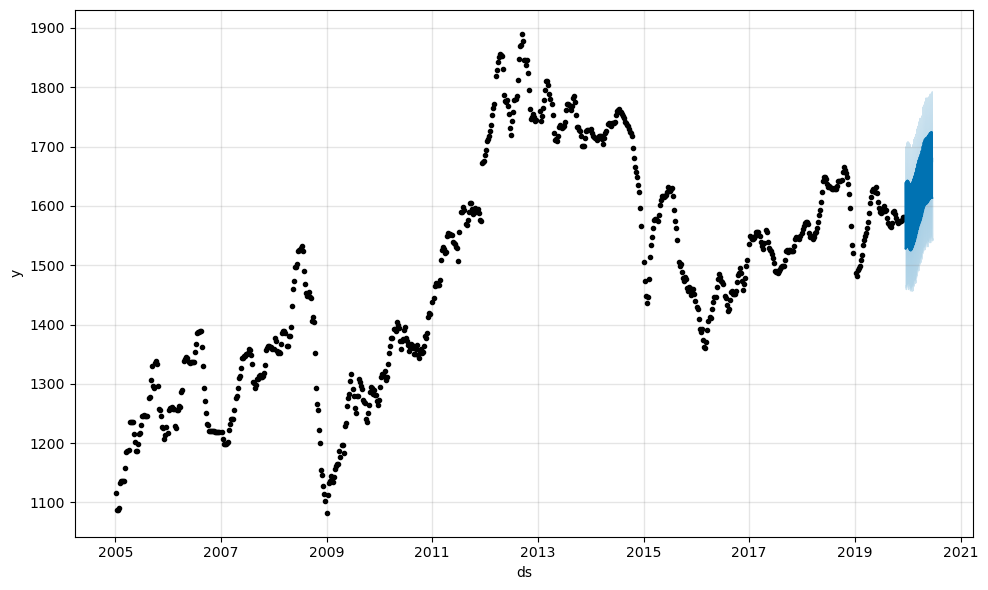

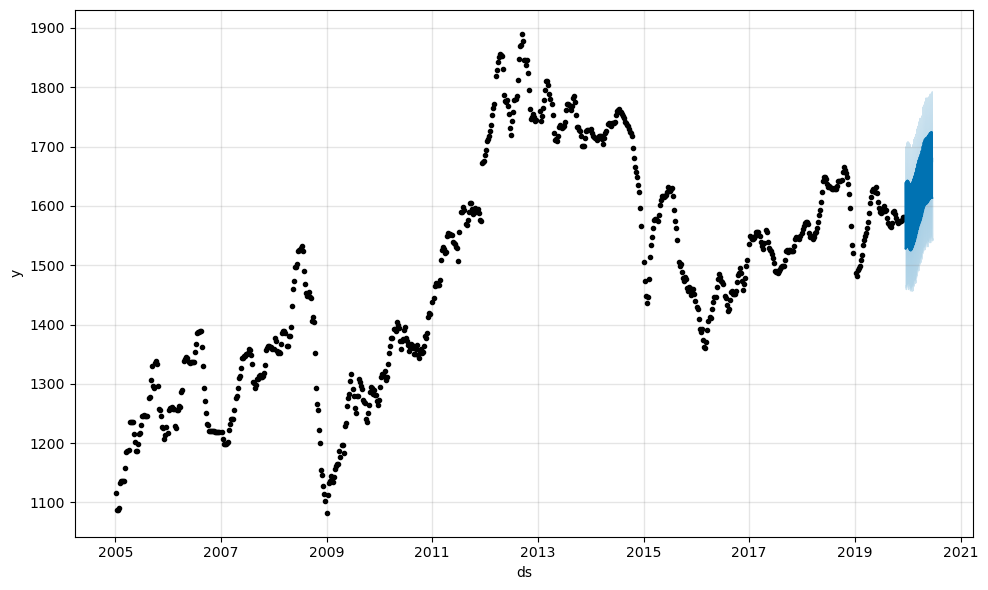

In [11]:
forecaster.plot(forecast)

An interactive figure of the forecast and components can be created with plotly. You will need to install plotly 4.0 or above separately, as it will not by default be installed with prophet. You will also need to install the notebook and ipywidgets packages

In [18]:
from prophet.plot import plot_plotly, plot_components_plotly

plot_plotly(forecaster, forecast)

In [19]:
plot_components_plotly(forecaster, forecast)


### Tracking Prophet algo with MLflow

In [20]:
from mlflow.models import infer_signature
import json
import pandas as pd
import numpy as np
from prophet import Prophet, serialize
from prophet.diagnostics import cross_validation, performance_metrics

In [21]:
def extract_params(pr_model):
    return {attr: getattr(pr_model, attr) for attr in serialize.SIMPLE_ATTRIBUTES}

In [22]:
artifact_path = "model"
with mlflow.start_run():
    model = Prophet().fit(train_df)

    params = extract_params(model)

    metric_keys = ["mse", "rmse", "mae", "mape", "mdape", "smape", "coverage"]
    metrics_raw = cross_validation(
        model=model,
        horizon="365 days",
        period="180 days",
        initial="710 days",
        parallel="threads",
        disable_tqdm=True,
    )
    cv_metrics = performance_metrics(metrics_raw)
    metrics = {k: cv_metrics[k].mean() for k in metric_keys}

    print(f"Logged Metrics: \n{json.dumps(metrics, indent=2)}")
    print(f"Logged Params: \n{json.dumps(params, indent=2)}")

    train = model.history
    predictions = model.predict(model.make_future_dataframe(30))
    signature = infer_signature(train, predictions)

    mlflow.prophet.log_model(model, artifact_path=artifact_path, signature=signature)
    mlflow.log_params(params)
    mlflow.log_metrics(metrics)
    model_uri = mlflow.get_artifact_uri(artifact_path)
    print(f"Model artifact logged to: {model_uri}")

17:05:47 - cmdstanpy - INFO - Chain [1] start processing
17:05:47 - cmdstanpy - INFO - Chain [1] done processing
17:05:47 - cmdstanpy - INFO - Chain [1] start processing
17:05:47 - cmdstanpy - INFO - Chain [1] start processing
17:05:47 - cmdstanpy - INFO - Chain [1] start processing
17:05:47 - cmdstanpy - INFO - Chain [1] start processing
17:05:47 - cmdstanpy - INFO - Chain [1] start processing
17:05:47 - cmdstanpy - INFO - Chain [1] start processing
17:05:47 - cmdstanpy - INFO - Chain [1] start processing
17:05:47 - cmdstanpy - INFO - Chain [1] start processing
17:05:47 - cmdstanpy - INFO - Chain [1] start processing
17:05:47 - cmdstanpy - INFO - Chain [1] start processing
17:05:47 - cmdstanpy - INFO - Chain [1] start processing
17:05:47 - cmdstanpy - INFO - Chain [1] start processing
17:05:47 - cmdstanpy - INFO - Chain [1] done processing
17:05:47 - cmdstanpy - INFO - Chain [1] done processing
17:05:47 - cmdstanpy - INFO - Chain [1] done processing
17:05:48 - cmdstanpy - INFO - Chain

Logged Metrics: 
{
  "mse": 27820.370998370683,
  "rmse": 160.57131479217503,
  "mae": 130.61153472195465,
  "mape": 0.08928081778965846,
  "mdape": 0.073744171624472,
  "smape": 0.09011291547201523,
  "coverage": 0.3064271749755621
}
Logged Params: 
{
  "growth": "linear",
  "n_changepoints": 25,
  "specified_changepoints": false,
  "changepoint_range": 0.8,
  "yearly_seasonality": "auto",
  "weekly_seasonality": "auto",
  "daily_seasonality": "auto",
  "seasonality_mode": "additive",
  "seasonality_prior_scale": 10.0,
  "changepoint_prior_scale": 0.05,
  "holidays_prior_scale": 10.0,
  "mcmc_samples": 0,
  "interval_width": 0.8,
  "uncertainty_samples": 1000,
  "y_scale": 1889.81,
  "logistic_floor": false,
  "country_holidays": null,
  "component_modes": {
    "additive": [
      "yearly",
      "weekly",
      "additive_terms",
      "extra_regressors_additive",
      "holidays"
    ],
    "multiplicative": [
      "multiplicative_terms",
      "extra_regressors_multiplicative"
   

/Users/dylantartarini/miniconda3/envs/epm/lib/python3.9/site-packages/mlflow/models/signature.py:137: UserWarning:

Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.

/Users/dylantartarini/miniconda3/envs/epm/lib/python3.9/site-packages/_distutils_hack/__init__.py:33: UserWarning:

Setuptools is replacing distutils.



In [23]:
loaded_model = mlflow.prophet.load_model(model_uri)

forecast = loaded_model.predict(loaded_model.make_future_dataframe(len(test_df)))

/Users/dylantartarini/miniconda3/envs/epm/lib/python3.9/site-packages/prophet/serialize.py:160: FutureWarning:

The behavior of Timestamp.utcfromtimestamp is deprecated, in a future version will return a timezone-aware Timestamp with UTC timezone. To keep the old behavior, use Timestamp.utcfromtimestamp(ts).tz_localize(None). To get the future behavior, use Timestamp.fromtimestamp(ts, 'UTC')



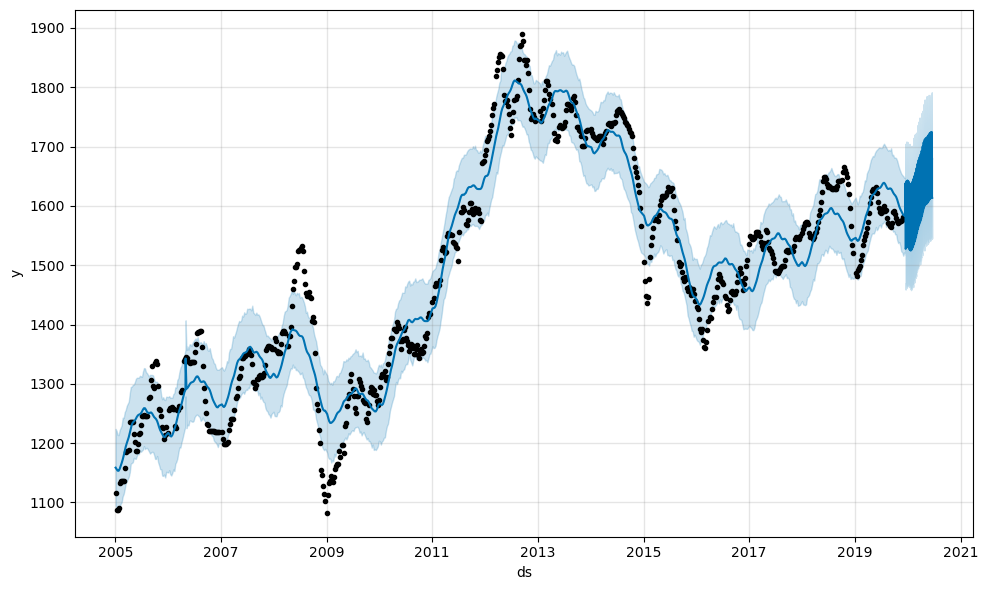

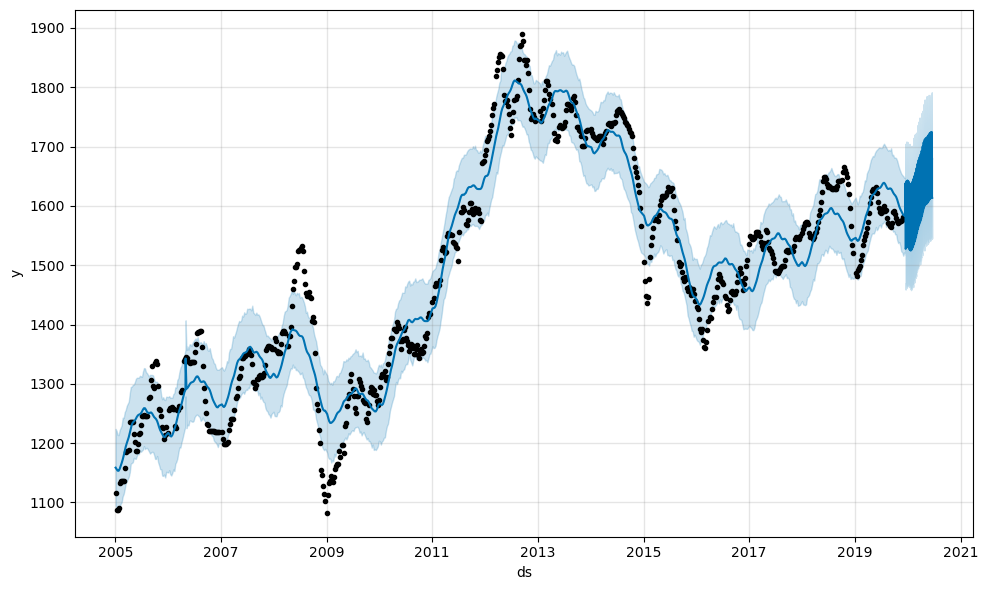

In [24]:
loaded_model.plot(forecast)